# **EECS 442 PS3: Panoramic Stitching**

__Please provide the following information__
(e.g. Drew Scheffer, drewskis):

Po-Hsun Chang, pohsun



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping.

3.1 You are given a npy file consisting the original points and target points. You want to find the homography transformation that map the original points to the destination points. Please generate 3 plots: original points, destination points, and mapped points
 for visualization

3.2 The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images.

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. **fit_homography** (2 points)

2. **apply_homography** (2 points)

1. **get_orb_features** (2 points)

2. **match_keypoints** (2 points)

3. **transform_ransac** (2 points)

4. **panoramic_stitching** (2 points)

Retreive the npy file online and convert to np array

In [16]:
%%capture
!wget -O file1.npy 'https://drive.google.com/uc?export=download&id=1WuDd_SKDXnCJkZb6EzNCX6Wn_dWF8w4A'

(1205, 4)


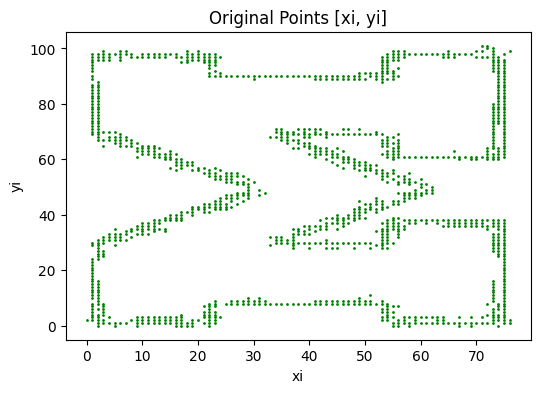

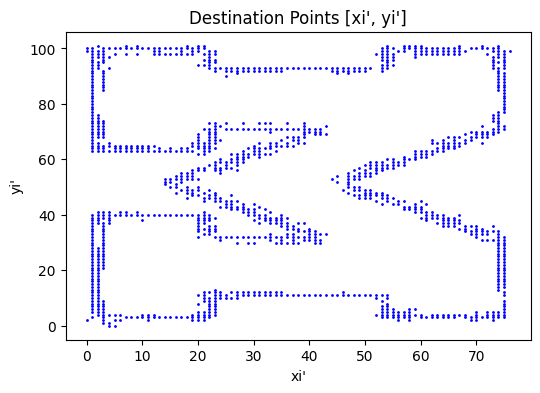

In [17]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load("file1.npy")
print(data.shape)

plt.figure(figsize=(6, 4))
plt.scatter(data[:, 0], data[:, 1], s=1, c='green')
plt.title('Original Points [xi, yi]')
plt.xlabel("xi")
plt.ylabel("yi")
plt.show()

# Plot for [xi', yi']
plt.figure(figsize=(6, 4))
plt.scatter(data[:, 2], data[:, 3], s=1, c='blue')
plt.title('Destination Points [xi\', yi\']')
plt.xlabel("xi'")
plt.ylabel("yi'")
plt.show()


#3.1 Homography estimation


Your first task is to implement a function fit_homography(pts1, pts2) that computes the homography matrix from a set of point correspondences.

This should fit a homography mapping between the two given points. You will use it to map the original points to the destination points.



In [18]:
def fit_homography(pts1, pts2):
	'''
	Given a set of N correspondences of the form [x,y], [x',y'],
	fit a homography that maps [x',y',1] to [x,y,1].

	Input - pts1, pts2: (N, 2) matrices representing N corresponding points [x, y] and [x', y']
	Output - H: a (3,3) homography matrix that (if the correspondences can be
					described by a homography) satisfies [x,y,1] === H [x',y',1]

	Use either nonlinear least squares or direct linear transform
	to find a homography that estimates the transformation mapping from pts2
	to pts1.
	e.g. If u = pts1[i] and v = pts2[i], then u = H * v in homogeneous coordinates

	Hint if using nonlinear least square:
		The objective function to optimize here is:
		\\sum_i ||pts1[i] - cart(H*homog(pts2[i]))||^2 where homog(x) converts x into
		homogeneous coordinates and cart(x) converts x to cartesian coordinates.
		You can use scipy.optimize.least_squares for this.

	Hint if using direct linear transform:
		The solution is given by the right-singular vector with the smallest singular value in the singular vector decomposition.
		You can use np.linalg.svd for this.

	Input:
		pts1, pts2: (N, 2) matrix
	Return:
		H: the resulting homography matrix (3 x 3)

	'''
	#############################################################################
	#                                   TODO                                    #
	#############################################################################
	from scipy.optimize import least_squares

	def homog(x):
		# Convert (N,2) to (N,3) homogeneous coordinates
		return np.hstack([x, np.ones((x.shape[0], 1))])

	def cart(x):
		# Convert (N,3) homogeneous to (N,2) cartesian coordinates
		return (x[:, :2].T / x[:, 2]).T

	def cost_fn(H0, pts1, pts2):
		H = H0.reshape(3, 3)
		pts2_h = homog(pts2)
		pts2_proj = (H @ pts2_h.T).T
		pts2_proj_cart = cart(pts2_proj)
		r = (pts1 - pts2_proj_cart).reshape(-1)
		return r

	H0 = np.ones(9) # Initial guess for homography
	res = least_squares(cost_fn, H0, args=(pts1, pts2))
	H = res.x.reshape(3, 3)
	return H
	#############################################################################
	#                             END OF YOUR CODE                              #
	#############################################################################

	return None

Visualize the original points, target points and points after applying a homography transform in three separate figures: original points, destination points, and mapped points


plt.scatter may be useful here


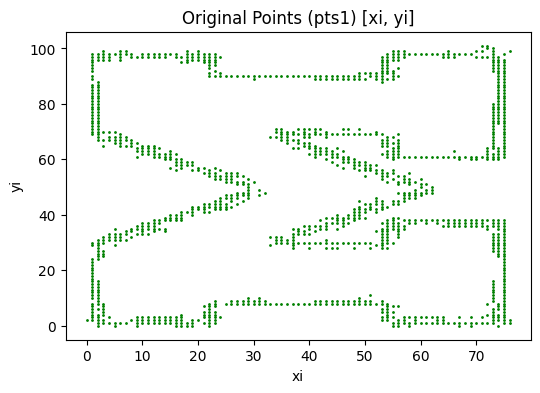

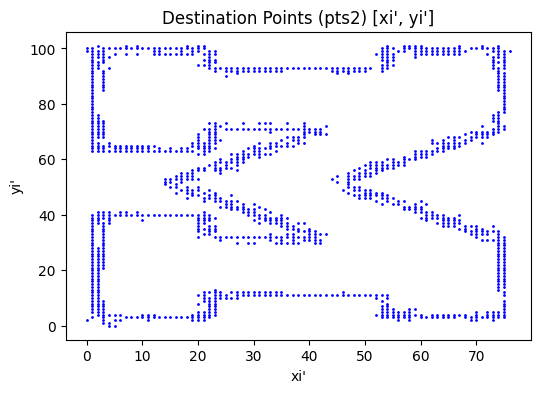

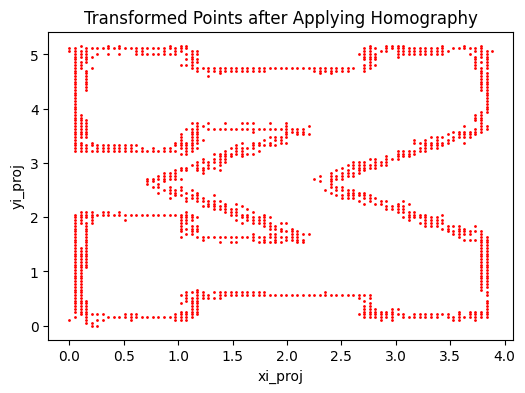

In [19]:
def apply_homography(data):
	'''
	Given loaded file1.npy, which is data, apply the transformation. data is in the
	form [x1,y1,x2,y2]

	Steps:
	1. Find the homography matrix
	2. Transform the data to homogeneous coordinates, then apply the transformation
	3. Transform the data back to Euclidean coordinates
	'''
	#############################################################################
	#                                   TODO                                    #
	#############################################################################

	# Find homography matrix
	pts1 = data[:, :2]	# original points
	pts2 = data[:, 2:]	# destination points
	H = fit_homography(pts2, pts1)	# H maps pts1 to pts2

	# Transform pts1 to homogeneous coordinates
	pts1_h = np.hstack([pts1, np.ones((pts1.shape[0], 1))])

	# Apply the homography to project pts1 to pts2 coordinates
	pts1_proj_cart = (H @ pts1_h.T).T

	# Plot 1: Original points (pts1) [xi, yi]
	plt.figure(figsize=(6, 4))
	plt.scatter(pts1[:, 0], pts1[:, 1], s=1, c='green')
	plt.title('Original Points (pts1) [xi, yi]')
	plt.xlabel("xi")
	plt.ylabel("yi")
	plt.show()

	# Plot 2: Destination points (pts2) [xi', yi']
	plt.figure(figsize=(6, 4))
	plt.scatter(pts2[:, 0], pts2[:, 1], s=1, c='blue')
	plt.title('Destination Points (pts2) [xi\', yi\']')
	plt.xlabel("xi'")
	plt.ylabel("yi'")
	plt.show()

	# Plot 3: Transformed points (pts1_proj_cart) after applying homography
	plt.figure(figsize=(6, 4))
	plt.scatter(pts1_proj_cart[:, 0], pts1_proj_cart[:, 1], s=1, c='red')
	plt.title('Transformed Points after Applying Homography')
	plt.xlabel("xi_proj")
	plt.ylabel("yi_proj")
	plt.show()
	return None

	#############################################################################
	#                             END OF YOUR CODE                              #
	#############################################################################

apply_homography(data)

# 3.2 Panoramic stitching

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [20]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [21]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1vHN5rBWj-sco8tcymzLkeu-DoMS1I8vi"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=1A26taOJAjhhEp_HJVsH3zvvFKtWMpaFe"

# Visualize Input Images

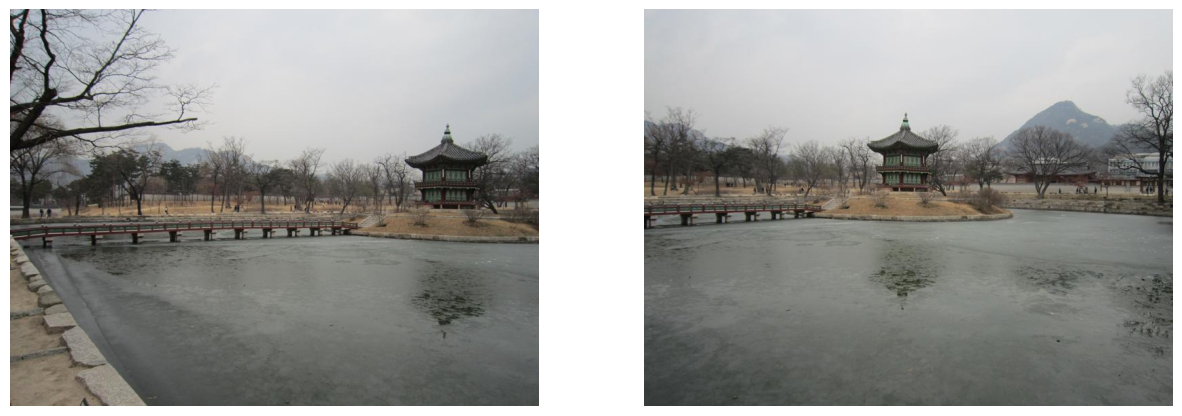

In [22]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
	fig, ax = plt.subplots(1, 2, figsize=(15, 20))
	for a in ax:
		a.set_axis_off()
	ax[0].imshow(img1)
	ax[1].imshow(img2)

plot_imgs(img1, img2)

# (a) Feature Extraction

## (i) Compute ORB Features

In [23]:
def get_orb_features(img):
	'''
	Compute ORB features using cv2 library functions.
	Use default parameters when computing the keypoints.
	Hint: you will need cv2.ORB_create() and some related functions
	Input:
		img: cv2 image
	Returns:
		keypoints: a list of cv2 keypoints
		descriptors: a list of ORB descriptors
	'''
	#############################################################################
	#                                   TODO                                    #
	#############################################################################
	orb = cv2.ORB_create()
	keypoints, descriptors = orb.detectAndCompute(img, None)
	#############################################################################
	#                             END OF YOUR CODE                              #
	#############################################################################
	return keypoints, descriptors


## (ii) Match Keypoints

In [24]:
def match_keypoints(desc_1, desc_2, ratio=0.75):
	'''
	Compute matches between feature descriptors of two images using
	Lowe's ratio test. You may use cv2 library functions.
	Hint: you may need to use cv2.DescriptorMatcher_create or cv2.BFMatcher
	and some related functions
	Input:
		desc_1, desc_2: list of feature descriptors
	Return:
		matches: list of feature matches
	'''
	#############################################################################
	#                                   TODO                                    #
	#############################################################################
	matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
	matches = matcher.match(desc_1, desc_2)
	matches = sorted(matches, key=lambda x: x.distance)
	#############################################################################
	#                             END OF YOUR CODE                              #
	#############################################################################

	return matches

keypoints for img1 and img2


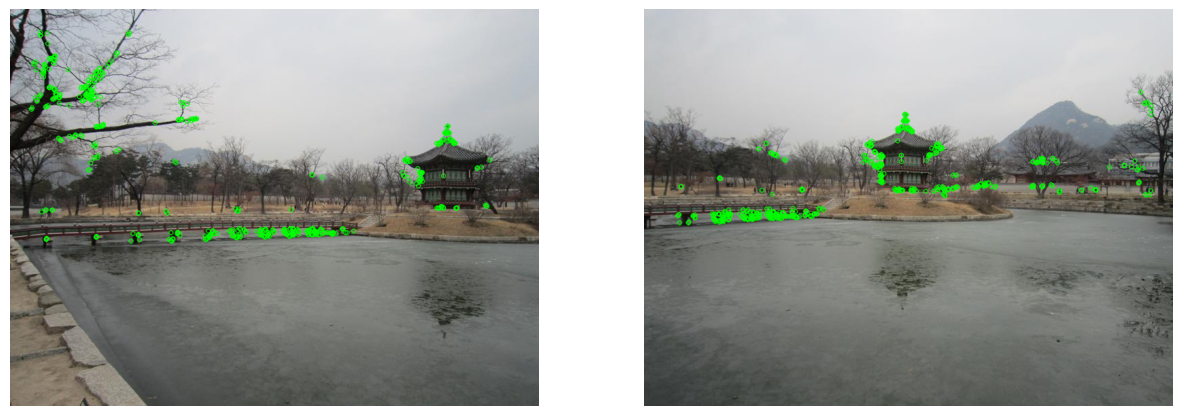

In [25]:
kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


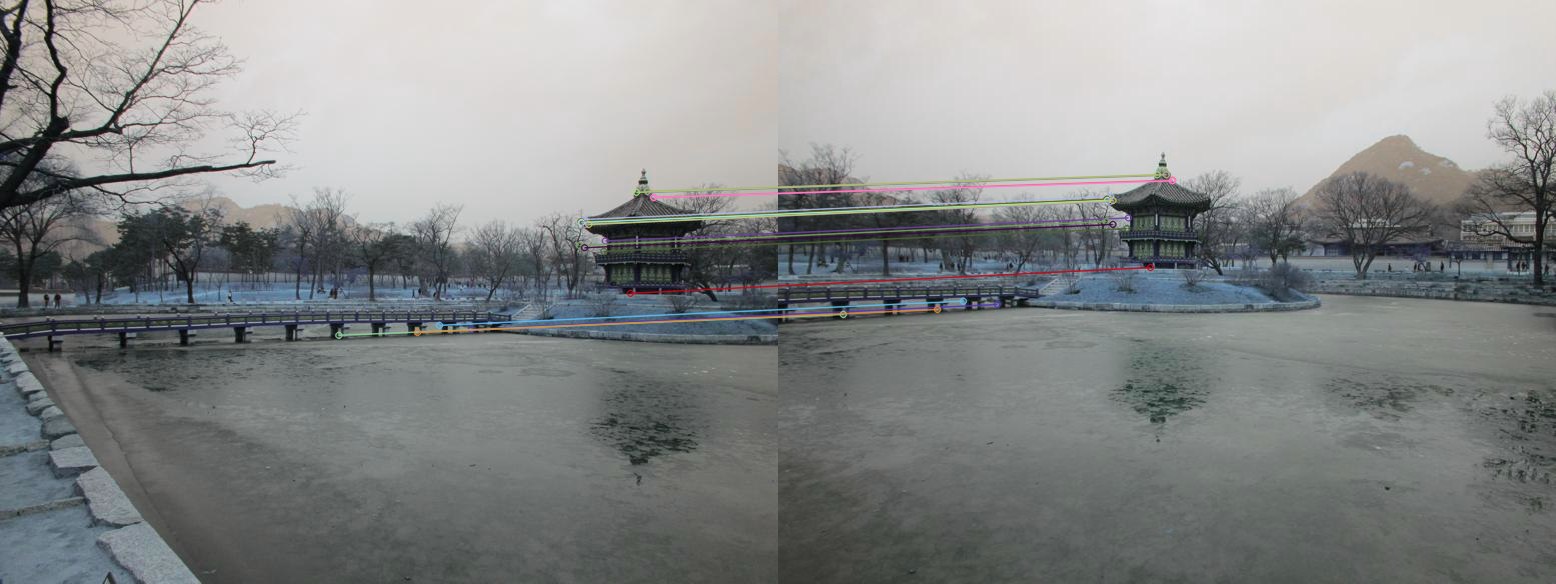

In [26]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# (b) Implement RANSAC

In [27]:
def transform_ransac(x1, x2, verbose=False):
	'''
	Implements RANSAC to estimate homography matrix.
	Hint: Follow the RANSAC steps outlined in the lecture slides.
	Input:
		pts_1, pts_2: (N, 2) matrices
	Return:
		best_model: homography matrix with most inliers
	'''
	#############################################################################
	#                                   TODO                                    #
	#############################################################################

	# RANSAC parameters
	max_iter = 100
	threshold = 3
	n_samples = 4
	best_inliers_idx = []
	best_model = None
	N = x1.shape[0]

	# Main RANSAC loop
	for i in range(max_iter):
		idx = np.random.choice(N, n_samples, replace=False)
		pts1_sample = x1[idx]
		pts2_sample = x2[idx]
		try:
			H = fit_homography(pts1_sample, pts2_sample)
		except Exception:
			continue
		# Project all x2 to x1 using H
		x2_h = np.hstack([x2, np.ones((N, 1))])
		x2_proj = (H @ x2_h.T).T
		x2_proj = x2_proj[:, :2] / x2_proj[:, 2][:, None]
		# Compute distances
		dists = np.linalg.norm(x1 - x2_proj, axis=1)
		inliers_idx = np.where(dists < threshold)[0]
		if len(inliers_idx) > len(best_inliers_idx):
			best_inliers_idx = inliers_idx
			best_model = H

	# Re-estimate H with all inliers
	if best_model is not None and len(best_inliers_idx) >= n_samples:
		best_model = fit_homography(x1[best_inliers_idx], x2[best_inliers_idx])
	#############################################################################
	#                             END OF YOUR CODE                              #
	#############################################################################
	return best_model

# (c) Panoramic Stitching

In [28]:
def panoramic_stitching(img1, img2):
	'''
		Given a pair of overlapping images, generate a panoramic image.
		Hint: use the functions that you've written in the previous parts.
		Input:
			img1, img2: images
		Return:
			final_img: image of panorama
	'''
	#############################################################################
	#                                   TODO                                    #
	# 1. detect keypoints and extract orb feature descriptors                   #
	# 2. match features between two images                                      #
	# 3. compute homography matrix H transforming points from pts_2 to pts_1.   #
	# Note the order here (not pts_1 to pts_2)!                                 #
	#############################################################################
	# 1. Get keypoints and descriptors from img1 and img2
	kp_1, desc_1 = get_orb_features(img1)
	kp_2, desc_2 = get_orb_features(img2)

	# 2. Match features between the two images
	matches = match_keypoints(desc_1, desc_2)

	# 3. transform_ransac
	pts1 = np.array([kp_1[m.queryIdx].pt for m in matches])
	pts2 = np.array([kp_2[m.trainIdx].pt for m in matches])
	H = transform_ransac(pts1, pts2)

	#############################################################################
	#                             END OF YOUR CODE                              #
	#############################################################################
	# apply perspective wrap to stitch images together
	final_img = cv2.warpPerspective(img2, H, (img2.shape[1] + img1.shape[1], img2.shape[0] * 2))
	final_img[0:img1.shape[0], 0:img1.shape[1]] = img1

	return final_img

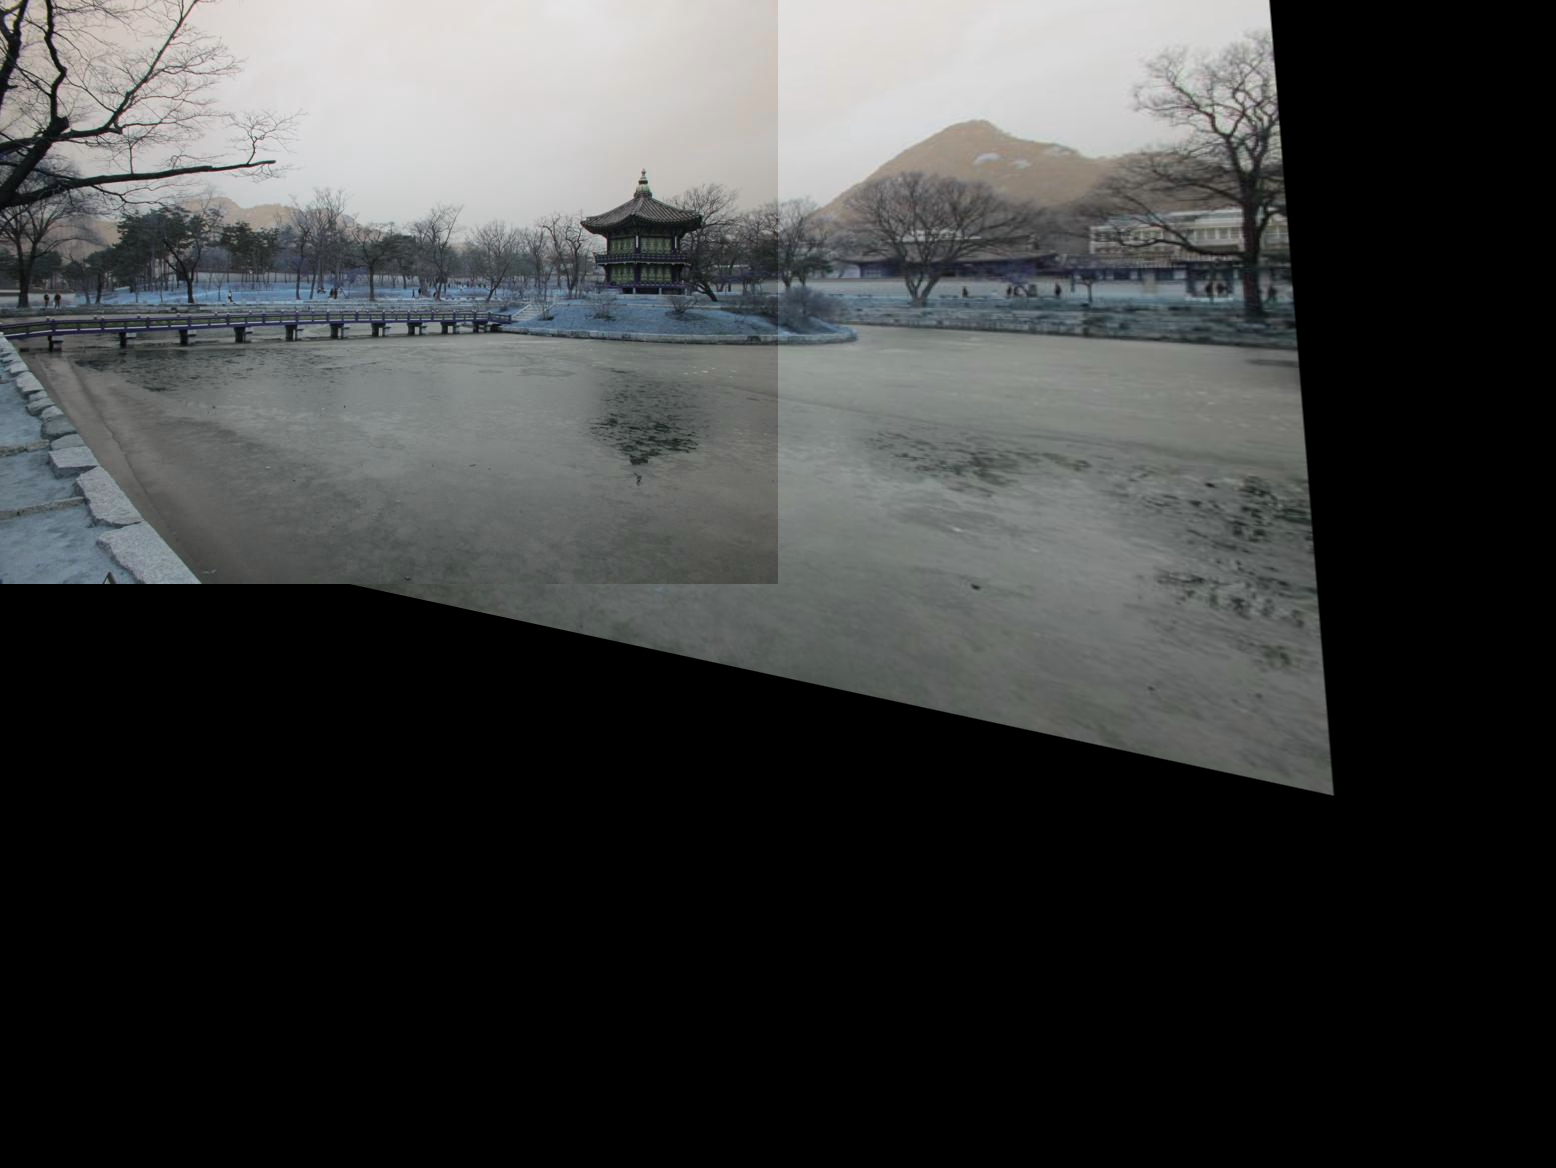

In [29]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)

# (d) Observe that in Figure 1, there is border artifacts in the stiched panorama. Describe methods that can remove the border artifacts for a smooth blending.

A: For my implementation to solve this problem, it will take the following 3 steps.
1. Crop the images so that so black boarder exists.
2. Adjust brightness and saturation of two images to reduce discrepency.
3. Utilize Gaussian and Laplacian pyramid and mask to blend the two images.

# Convert to PDF
Before converting to pdf, please get rid of the **funuction points declaration text** starts with "Functions to implement (refer to function comments for more detail)" of the brief overview section at the top. That part of text requires specific latex libaraies for conversion and may affect your pdf conversion process.

This may be important if you have failed converting to pdf.


In [30]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '/content/drive/My Drive/EECS 442 - Computer Vision/Hw/hw3/pohsun_40183452.ipynb' # Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/drewskis_31415926.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
40 pa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>